# Pre-Processing & Modeling

### Imports

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Processing and Models
import regex as re
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Pre-processing

In [3]:
# read in csv files
posts = pd.read_csv('../data/posts_clean.csv')
posts.head()

,subreddit,text
0,0,https://www.dailymail.co.uk/news/article-7922...
1,0,There is a search engine called [Ecosia](https...
2,0,[Vandana Shiva](https://youtu.be/MNM833K22LM) ...
3,0,"If you have a weak stomach, I wouldn’t watch t..."
4,0,Breathing Pattern Disorders Caused by Environ...


In [4]:
# check duplicates
posts.duplicated().sum()

62

In [5]:
# Drop second duplicated column
posts.drop_duplicates(keep='first', inplace=True)

In [6]:
# Check shape
posts.shape

(5455, 2)

In [7]:
# Clean the text column by removing html code 
# and making all letters lowercase
posts["text"] = posts["text"].str.replace('[^a-zA-Z ]', ' ')
posts["text"] = posts["text"].str.replace(r'http\S+', '')
posts["text"] = posts["text"].str.replace(r'\[http\S+', '')
posts["text"] = [post.lower().strip() for post in posts['text']]

In [8]:
# Separate dataframes for each subreddit
env_posts = posts[posts['subreddit']==0]
tech_posts = posts[posts['subreddit']==1]

# Get character count for each subreddit
env_char = sum([len(post) for post in env_posts['text']])
tech_char = sum([len(post) for post in tech_posts['text']])

# Get average post length
env_avg = env_char / len(env_posts)
tech_avg = tech_char / len(tech_posts)
                           
print(f"r/environment has {env_char - tech_char} more characters than r/technology.")
print(f"Average character count for r/environment posts: {env_avg}")
print(f"Average character count for r/technology posts: {tech_avg}")

r/environment has 1462650 more characters than r/technology.
Average character count for r/environment posts: 829.125960061444
Average character count for r/technology posts: 244.2630655910207


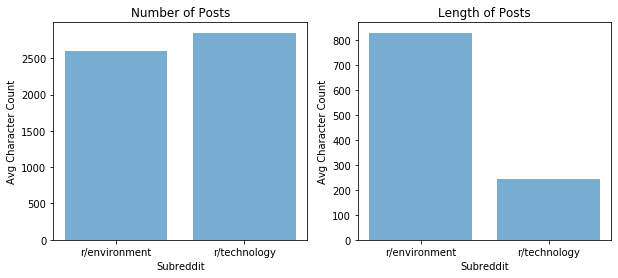

In [9]:
plt.figure(figsize=(10,4)) 

objects = ('r/environment', 'r/technology')
y_pos = np.arange(len(objects))
height1 = [len(env_posts), len(tech_posts)]
height2 = [env_avg, tech_avg]

# Visualize difference in number of posts
plt.subplot(1,2,1)
plt.bar(y_pos, height1, align='center', alpha=0.6,)
plt.xticks(y_pos, objects)
plt.xlabel('Subreddit')
plt.ylabel('Avg Character Count')
plt.title('Number of Posts')

# Visualize difference in avg post length
plt.subplot(1,2,2)
plt.bar(y_pos, height2, align='center', alpha=0.6,)
plt.xticks(y_pos, objects)
plt.ylabel('Avg Character Count')
plt.xlabel('Subreddit')
plt.title('Length of Posts');

### Train, test, split

In [10]:
# prepare the data for modeling
X = posts['text']
y = posts['subreddit']

In [13]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
# Get the number of posts for X train (4091)
total_posts = X_train.shape[0]
print(f'There are a total of {total_posts} posts in the training set.')

There are a total of 4091 posts in the training set.


## CountVectorize

In [15]:
# Add my own stopwords to SKlearn's set of stopwords
stops_sk = ENGLISH_STOP_WORDS.union({'http', 'https', 'www', 'com', 'org', 'amp'})

# Add my own stopwords to nltk's set of stopwords
stops_nltk = stopwords.words('english') + ['http', 'https', 'www', 'com', 'org', 'amp']

In [16]:
# Use CountVectorize to explore common words
cvec = CountVectorizer(stop_words=stops_sk, ngram_range=(1, 1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

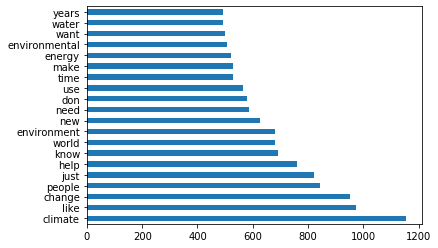

In [17]:
# Put vectorized words into a df to explore - todense() will return a dense matrix
words = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())

# check which words are appearing the most
words.sum().sort_values(ascending=False).head(20).plot(kind='barh');

### Tokenize, Stem, Lemmatize

In [18]:
# Instantiate tokenizer and stemmer
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

# Stem X_train and save words to empty list
stemmed_words=[]

for word in X_train:
    tokens = tokenizer.tokenize(word)
    row = [p_stemmer.stem(token) for token in tokens]
    stemmed_words.append(row)

In [19]:
# Join the stemmed words together and save as X_train
X_train = [' '.join(row) for row in stemmed_words]
X_train[:1]

['from game or phone interfac vr or keyboard and mous or ani other peripher to ani other type of user interfac what do you think is a realli obviou improv that s miss for exampl when i m in firefox and i ctrl t to open a new tab my cursor is in the search bar but if i go type say youtub and want to search there onc it load now i have to take my hand off the keyboard to click the right field to start type or tab an unknown per page number of time through invis menu frame that don t highlight until i get the cursor to the search bar whi isn t there some kind of default focu flag in css or on page in gener that can say onc load in focu set cursor here so develop can tag their search bar as their start point if there is whi the badword don t youtub use it let s talk ui what improv would make your day to day experi better while use ani devic or softwar']

In [20]:
# Stem X_test and save words to empty list
stemmed_words=[]

for word in X_test:
    tokens = tokenizer.tokenize(word)
    row = [p_stemmer.stem(token) for token in tokens]
    stemmed_words.append(row)

In [21]:
# Join the stemmed words together and save as X_test
X_test = [' '.join(row) for row in stemmed_words]
X_test[:2]

['thi is break news will chang text onc link is avail the ravin bushfir on kangaroo island south australia ha been contain after more than three week of activ firefight',
 'my last post on thi topic got delet what are devic that onli messag with no servic or wifi at all up to an mile rang like a devic transmitt or app']

# Modeling

In [22]:
# Get baseline accuracy
y_test.value_counts(normalize=True)

1    0.522727
0    0.477273
Name: subreddit, dtype: float64

The dataset is slightly unbalanced. The baseline accuracy will be based off the majority class (1), so it is 52.26%. If we see accuracy scores lower than the baseline accuracy it would indicate the models are performing worse than randomly guessing 52.26% of the posts are coming from the technology subreddit.  

## Logistic Regression
I start with a logistic regression model because it is easy to interpret and can indicate which variables are considered important by the model. Count vectorizer provides a numeric representation of how often certain words appear in a document.

In [26]:
pipe_cvec_lr = Pipeline([('cvec', CountVectorizer()),
                         ('lr', LogisticRegression(random_state=42))])

In [27]:
params_cvec_lr = {
    'cvec__stop_words':[stops_sk, stops_nltk],
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.85, .9],
    'cvec__ngram_range': [(1,1), (1,2)], 
    'lr__C': [0.01, 0.1, 1, 10]
}

# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe_cvec_lr,
                  param_grid=params_cvec_lr, 
                  cv=3) 

# Fit GridSearch to training data.
gs_cvec_lr.fit(X_train, y_train)

# Score model and check best params/model
print(f'Best Score: {gs_cvec_lr.best_score_}')
print(f'Train Score: {gs_cvec_lr.score(X_train, y_train)}')
print(f'Test Score: {gs_cvec_lr.score(X_test, y_test)}')
print(f'Best Params: {gs_cvec_lr.best_params_}')

Best Score: 0.9269157147887652
Train Score: 0.9848447812270839
Test Score: 0.9288856304985337
Best Params: {'cvec__max_df': 0.85, 'cvec__max_features': 2500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'un

In [28]:
# Generate predictions
gs_cvec_lr_preds = gs_cvec_lr.predict(X_test)

In [29]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, gs_cvec_lr_preds).ravel()

# Calculate sensitivity and specificity
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec,4)}')
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.8909
Sensitivity: 0.9635


### Interpretation
- The model has a strong performance, with the train set scoring higher than the test set - model is overfitting to the data.
- hyperparameters: considering trying lower values for max_df

## Logistic Regression 2
TFIDFVectorizer returns a word's value proportionally to count. It is offset by the frequency of the word in the corpus.

In [26]:
pipe_tfidf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                         ('lr', LogisticRegression(random_state=42, max_iter=400))])

In [27]:
# Search over the following values of hyperparameters:
params_tfidf_lr = {
    'tfidf__stop_words':[stops_sk, stops_nltk],
    'tfidf__max_features': [3000, 3500],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,2)],
    'lr__C': [10, 15, 20]
}

# Instantiate GridSearchCV
gs_tfidf_lr = GridSearchCV(pipe_tfidf_lr,
                  param_grid=params_tfidf_lr, 
                  cv=3) 

# Fit GridSearch to training data.
gs_tfidf_lr.fit(X_train, y_train)

# Score model and check best params/model
print(f'Best Score: {gs_tfidf_lr.best_score_}')
print(f'Train Score: {gs_tfidf_lr.score(X_train, y_train)}')
print(f'Test Score: {gs_tfidf_lr.score(X_test, y_test)}')
print(f'Best Params: {gs_tfidf_lr.best_params_}')

Best Score: 0.9408471265084998
Train Score: 0.9958445367880714
Test Score: 0.9464809384164223
Best Params: {'lr__C': 15, 'tfidf__max_df': 0.9, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', '

In [32]:
# Generate predictions
gs_tfidf_lr_preds = gs_tfidf_lr.predict(X_test)

In [33]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, gs_tfidf_lr_preds).ravel()

# Calculate sensitivity and specificity
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec,4)}')
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9247
Sensitivity: 0.9691


### Interpretation
- The model outperformed the baseline and performed better than the logistic regression model using Countvectorizer
- The models are classifying very well, but this is not great for my problem statement! There is a clear distinction between the technology and environment subreddits.

## Multinomial Naive Bayes
A Multinomial Naive Bayes model is used because count vectorizer gives us an integer count of words in a document. It's a very fast modeling algorithm and an excellent classifier, outperforming more complicated models.

In [34]:
# Instantiate Naive Bayes model
mnb = MultinomialNB()
cvec = CountVectorizer()

# Countvectorize on x_train and x_test data
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

# Fit MNB to training data
mnb.fit(X_train_cvec, y_train)

# Make predictions
y_pred_train = mnb.predict(X_train_cvec)
y_pred_test = mnb.predict(X_test_cvec)

# Score model and check best params/model
print(f'Train Score: {mnb.score(X_train_cvec, y_train)}')
print(f'Test Score: {mnb.score(X_test_cvec, y_test)}') 

Train Score: 0.9643119041799071
Test Score: 0.9332844574780058


In [35]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

# Calculate sensitivity and specificity
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec,4)}')
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9739
Sensitivity: 0.8962


### Interpretation
- It was worth testing this model, but important to recognize it's shortcomings. Naive Bayes models assume that all of our features are independent of one another, which isn't necessarily true with language data. Certain words are more likely to follow other words, and certain words are less likely to follow other words.

## Random Forest
Random Forests are relatively simple to use because they require very few parameters to set and they perform pretty well. 

In [36]:
pipe_tfidf_rf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('rf', RandomForestClassifier(random_state=42))])

In [37]:
params_tfidf_rf ={
    'tfidf__stop_words':[stops_nltk],
    'tfidf__max_features': [2500, 3000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators':[50,100],
    'rf__max_depth':[None,1,2,3,4],
    'rf__min_samples_split':[2,4,6]
}

# Instantiate Gridsearch
gs_tfidf_rf = GridSearchCV(pipe_tfidf_rf, 
                     param_grid=params_tfidf_rf, 
                     cv=3)

# Fit Gridsearch to the training data
gs_tfidf_rf.fit(X_train, y_train)

# Score model and check best params/model
print(f'Best Params: {gs_tfidf_rf.best_params_}')
print(f'Best Score: {gs_tfidf_rf.best_score_}')
print(f'Train Score: {gs_tfidf_rf.score(X_train, y_train)}')
print(f'Test Score: {gs_tfidf_rf.score(X_test, y_test)}') 

Best Params: {'rf__max_depth': None, 'rf__min_samples_split': 4, 'rf__n_estimators': 100, 'tfidf__max_df': 0.9, 'tfidf__max_features': 2500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

In [38]:
# Generate predictions
gs_tfidf_rf_preds = gs_tfidf_rf.predict(X_test)

In [39]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, gs_tfidf_rf_preds).ravel()

# Calculate sensitivity and specificity
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec,4)}')
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9309
Sensitivity: 0.9116


### Interpretation
- The Random Forest Model is overfit, indicated by the significantly higher training score. This can also be concluded because the best max_depth parameter is 'None', which indicates an overfit tree.
- As we increased variation by adding the min samples split parameter, we saw a slight decrease in the model's performance. The min_samples_split parameter could be driving max_depth to none. 
- Parameters indicate a lower number of trees is ideal.

| model | transformer | estimator | train accuracy | test accuracy | sensitivity | specificity |
|-------|--------------|-------------|-----------------|----------|------------|------------------|
| 1 | CountVectorizer | Logistic Regression | 98.5% | 92.9% | 96.4% | 89.1% |
| 2 | TfidfVectorizer | Logistic Regression | 99.6% | 94.6% | 96.9% | 92.5% |
| 3 | CountVectorizer | Multinomial Naive Bayes | 96.4% | 93.3% | 89.6% | 97.4% |
| 4 | TfidfVectorizer | Random Forest Classifier | 99.8% | 92.1% | 91.2% | 93.1% |

# References

Preprocessing and EDA  
https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python  
https://pythonspot.com/matplotlib-bar-chart/  